In [1]:
import os
import sys
import requests
import datetime
import pandas as pd
import numpy as np
import torch, torchvision, torchaudio
import pytorch_lightning as pl
import wandb
import json
import copy
import shutil
import matplotlib.pyplot as plt
import time

from torchmetrics.detection import MeanAveragePrecision
from coco_eval import CocoEvaluator
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
from pytorch_lightning.loggers import WandbLogger
from transformers import AutoImageProcessor, DetaForObjectDetection
from transformers import DetaConfig, DetaImageProcessor
from pytorch_lightning import Trainer
from PIL import Image, ImageDraw

In [2]:
class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, processor, image_name):
        ann_file = os.path.join(img_folder, image_name)
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.processor = processor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        # feel free to add data augmentation here before passing them to the next step
        img, target = super(CocoDetection, self).__getitem__(idx)

        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.processor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target

processor = DetaImageProcessor.from_pretrained("jozhang97/deta-resnet-50")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create Train and Validation Dataset
  #Minimal Dataset
# train_dataset = CocoDetection(img_folder='../../../old/BAA/Data/train', processor=processor, image_name="coco_train.json")
# val_dataset = CocoDetection(img_folder='../../../old/BAA/Data/val', processor=processor, image_name="coco_val.json")

  #Maximal Dataset
train_dataset = CocoDetection(img_folder='../../../old/BAA/Data/train_Schmutz', processor=processor, image_name="coco_train.json")
val_dataset = CocoDetection(img_folder='../../../old/BAA/Data/val_Schmutz', processor=processor, image_name="coco_val.json")

print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

def collate_fn(batch):
  pixel_values = [item[0] for item in batch]
  encoding = processor.pad(pixel_values, return_tensors="pt")
  labels = [item[1] for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = labels
  return batch

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=1, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=1)
batch = next(iter(train_dataloader))



loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Number of training examples: 859
Number of validation examples: 215


In [3]:
class Deta(pl.LightningModule):
	def __init__(self, lr, lr_backbone, weight_decay):
		super().__init__()
		# replace COCO classification head with custom head
		# we specify the "no_timm" variant here to not rely on the timm library
		# for the convolutional backbone
		self.model = DetaForObjectDetection.from_pretrained("jozhang97/deta-resnet-50",
															num_labels=len(id2label),
															auxiliary_loss=True,
															ignore_mismatched_sizes=True)
		# see https://github.com/PyTorchLightning/pytorch-lightning/pull/1896
		self.processor = DetaImageProcessor.from_pretrained("jozhang97/deta-resnet-50")
		self.save_hyperparameters()
		self.val_epoch_count = 0 # to not log at the first run
		self.lr = lr
		self.lr_backbone = lr_backbone
		self.weight_decay = weight_decay
		self.training_step_pred = []
		self.training_step_targ = []
		self.validation_step_pred = []
		self.validation_step_targ = []

	def forward(self, pixel_values, pixel_mask):
		outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)
		return outputs

	def common_step(self, batch, batch_idx, t_v):
		pixel_values = batch["pixel_values"]
		pixel_mask = batch["pixel_mask"]
		labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

		outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

		loss = outputs.loss
		loss_dict = outputs.loss_dict

		#if t_v:
		#	self.data_prep_train(pixel_values, pixel_mask, labels)
		#else:
		#	self.data_prep_val(pixel_values, pixel_mask, labels)

		return loss, loss_dict

	def training_step(self, batch, batch_idx):
		loss, loss_dict = self.common_step(batch, batch_idx, True)
		# logs metrics for each training_step,
		# and the average across the epoch
		self.log("training_loss", loss)
		for k,v in loss_dict.items():
			self.log("train_" + k, v.item())
		return loss
	
	"""def on_train_epoch_end(self) -> None:
		print("onTrainEpoch")
		t1 = time.time()
		self.cmetric = MeanAveragePrecision(iou_type="bbox")
		self.cmetric.update(self.training_step_pred, self.training_step_targ)
		result = self.cmetric.compute()
		counter = 0
		for k, v in result.items():
			counter += 1
			if counter < 15:
				wandb.log({"train_epoch_" + k: v.item()})
				print({"train_" + k: v.item()})
		self.training_step_pred = []
		self.training_step_targ = []
		t2 = time.time()
		print(round(t2 - t1, 4))"""

	def validation_step(self, batch, batch_idx):
		loss, loss_dict = self.common_step(batch, batch_idx, False)
		self.log("validation_loss", loss)
		for k,v in loss_dict.items():
			self.log("validation_" + k, v.item())
		return loss
	
	"""def on_validation_epoch_end(self) -> None:
		if self.val_epoch_count == 1:
			print("onValEpoch")
			t1 = time.time()
			self.cmetric = MeanAveragePrecision(iou_type="bbox")
			self.cmetric.update(self.training_step_pred, self.training_step_targ)
			result = self.cmetric.compute()
			counter = 0
			for k, v in result.items():
				counter += 1
				if counter < 15:
					wandb.log({"validation_epoch_" + k: v.item()})
					print({"validation_epoch_" + k: v.item()})
			self.validation_step_pred = []
			self.validation_step_targ = []
			t2 = time.time()
			print(round(t2 - t1, 4))
		else:
			self.val_epoch_count = 1"""

	def configure_optimizers(self):
		param_dicts = [
				{"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
				{
					"params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
					"lr": self.lr_backbone,
				},
		]
		optimizer = torch.optim.AdamW(param_dicts, lr=self.lr,
									weight_decay=self.weight_decay)

		return optimizer

	def train_dataloader(self):
		return train_dataloader

	def val_dataloader(self):
		return val_dataloader
	
	"""def data_prep_train(self, pixel_values, pixel_mask, labels):

		with torch.no_grad():
			outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

		orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
		results = self.processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes, threshold=0)
		for n in results:
			self.training_step_pred.append(n)
		for i in labels:
			self.training_step_targ.append({"boxes":i["boxes"], "labels":i["class_labels"]})

	def data_prep_val(self, pixel_values, pixel_mask, labels):

		with torch.no_grad():
			outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

		orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
		results = self.processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes, threshold=0)
		for n in results:
			self.validation_step_pred.append(n)
		for i in labels:
			self.validation_step_targ.append({"boxes":i["boxes"], "labels":i["class_labels"]})"""

In [4]:
# Training

# login to weights and biases, to relogin: wandb.login(key="YOUR KEY", relogin=True)
wandb.login()

date = datetime.datetime.now()
run_name = "Run at the {}".format(date)

lr = 1e-4
lr_backbone=1e-5
weight_decay=1e-4

project = "BAA_Book_Damage_Detection"

wandb.init(
    project=project,
    name=run_name,
    config={"learning_rate_transformer": lr,
            "learning_rate_backbone": lr_backbone,
            "weight_decay": weight_decay,
            "architecture": "DETA",
            "dataset": "All_Data_Schmutz",
            "train_set_size": len(train_dataset)}
    )

model = Deta(lr=lr, lr_backbone=lr_backbone, weight_decay=weight_decay)

model.to(device)

# outputs = model(pixel_values=batch['pixel_values'].to(device), pixel_mask=batch['pixel_mask'].to(device))
# print(outputs.logits.shape)

max_steps_var = 1900

wandb_logger = WandbLogger("DETA", "../models/", project=project, log_model=True, checkpoint_name=f"DETA_Schmutz_{max_steps_var}_Steps")
trainer = Trainer(max_steps=max_steps_var, gradient_clip_val=0.1, logger=wandb_logger)
trainer.fit(model)

wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: michael-infanger (damaged-books-detection-ml). Use `wandb login --relogin` to force relogin


Some weights of DetaForObjectDetection were not initialized from the model checkpoint at jozhang97/deta-resnet-50 and are newly initialized because the shapes did not match:
- model.decoder.class_embed.0.bias: found shape torch.Size([91]) in the checkpoint and torch.Size([10]) in the model instantiated
- model.decoder.class_embed.0.weight: found shape torch.Size([91, 256]) in the checkpoint and torch.Size([10, 256]) in the model instantiated
- model.decoder.class_embed.1.bias: found shape torch.Size([91]) in the checkpoint and torch.Size([10]) in the model instantiated
- model.decoder.class_embed.1.weight: found shape torch.Size([91, 256]) in the checkpoint and torch.Size([10, 256]) in the model instantiated
- model.decoder.class_embed.2.bias: found shape torch.Size([91]) in the checkpoint and torch.Size([10]) in the model instantiated
- model.decoder.class_embed.2.weight: found shape torch.Size([91, 256]) in the checkpoint and torch.Size([10, 256]) in the model instantiated
- model.de

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Michael\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\Michael\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\utilities\data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\Michael\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1900` reached.


# Load Checkpoint
from Weights & Biases (Artifacts)

In [6]:
run = wandb.init()
artifact = run.use_artifact('damaged-books-detection-ml/BAA_Book_Damage_Detection/DETA_Schmutz_1900_Steps:v0', type='model')
artifact_dir = artifact.download()

model = Deta.load_from_checkpoint(artifact_dir + "/model.ckpt")
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

wandb: Downloading large artifact DETA_Schmutz_1900_Steps:v0, 551.94MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.5
Some weights of DetaForObjectDetection were not initialized from the model checkpoint at jozhang97/deta-resnet-50 and are newly initialized because the shapes did not match:
- model.decoder.class_embed.0.bias: found shape torch.Size([91]) in the checkpoint and torch.Size([10]) in the model instantiated
- model.decoder.class_embed.0.weight: found shape torch.Size([91, 256]) in the checkpoint and torch.Size([10, 256]) in the model instantiated
- model.decoder.class_embed.1.bias: found shape torch.Size([91]) in the checkpoint and torch.Size([10]) in the model instantiated
- model.decoder.class_embed.1.weight: found shape torch.Size([91, 256]) in the checkpoint and torch.Size([10, 256]) in the model instantiated
- model.decoder.class_embed.2.bias: found shape torch.Size([91]) in the checkpoint and torch.Size([10]) in the model instantiated
- model.decoder.cl

Deta(
  (model): DetaForObjectDetection(
    (model): DetaModel(
      (backbone): DetaBackboneWithPositionalEncodings(
        (model): ResNetBackbone(
          (embedder): ResNetEmbeddings(
            (embedder): ResNetConvLayer(
              (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
              (normalization): DetaFrozenBatchNorm2d()
              (activation): ReLU()
            )
            (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          )
          (encoder): ResNetEncoder(
            (stages): ModuleList(
              (0): ResNetStage(
                (layers): Sequential(
                  (0): ResNetBottleNeckLayer(
                    (shortcut): ResNetShortCut(
                      (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                      (normalization): DetaFrozenBatchNorm2d()
                    )
                    (layer):

# Evaluation

#### Funtion Declaration

In [7]:
def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)

def prepare_for_coco_detection(predictions):
    coco_results = []
    for original_id, prediction in predictions.items():
        if len(prediction) == 0:
            continue

        boxes = prediction["boxes"]
        boxes = convert_to_xywh(boxes).tolist()
        scores = prediction["scores"].tolist()
        labels = prediction["labels"].tolist()

        coco_results.extend(
            [
                {
                    "image_id": original_id,
                    "category_id": labels[k],
                    "bbox": box,
                    "score": scores[k],
                }
                for k, box in enumerate(boxes)
            ]
        )
    return coco_results

#### Run Evaluation

In [14]:
# initialize evaluator with ground truth (gt)
evaluator = CocoEvaluator(coco_gt=val_dataset.coco, iou_types=["bbox"])

print("Running evaluation...")
for idx, batch in enumerate(tqdm(val_dataloader)):
    # get the inputs
    pixel_values = batch["pixel_values"].to(device)
    pixel_mask = batch["pixel_mask"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]] # these are in DETR format, resized + normalized

    # forward pass
    with torch.no_grad():
      outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    # turn into a list of dictionaries (one item for each example in the batch)
    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes, threshold=0)

    # provide to metric
    # metric expects a list of dictionaries, each item
    # containing image_id, category_id, bbox and score keys
    predictions = {target['image_id'].item(): output for target, output in zip(labels, results)}
    predictions = prepare_for_coco_detection(predictions)
    evaluator.update(predictions)

evaluator.synchronize_between_processes()
evaluator.accumulate()
evaluator.summarize()

Running evaluation...


  0%|          | 0/215 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.11s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.031
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.103
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.040
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.024
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.035
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.026
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.100
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.183
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.177
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.171
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

# Visualize

{'scores': tensor([0.2825, 0.2797, 0.2788, 0.2787, 0.2768, 0.2752, 0.2752, 0.2525, 0.2521,
        0.2476, 0.2442, 0.2320, 0.2287, 0.2205, 0.2190, 0.2145, 0.2044, 0.2026,
        0.2021, 0.1996, 0.1923, 0.1846], device='cuda:0'), 'labels': tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0'), 'boxes': tensor([[ 456.8139,  554.9907,  471.8331,  581.1669],
        [ 455.3461,  552.7808,  477.0996,  588.2291],
        [ 457.0282,  557.1699,  471.0413,  575.4336],
        [ 355.7174,  845.6071,  372.4727,  868.6250],
        [ 352.9490,  843.8126,  373.0705,  871.4369],
        [ 457.5827,  558.5644,  476.1583,  576.3024],
        [ 353.4857,  847.8851,  375.2311,  869.2444],
        [ 811.7747,  300.3368,  835.8522,  349.3704],
        [ 978.3085,  788.6262,  995.4892,  806.7751],
        [ 978.8514,  787.1258,  994.8947,  802.8995],
        [ 982.5744,  785.5987,  997.6862,  807.1193],
        [1162.2427,  859.9307, 1180.1177,  908.6290],
   

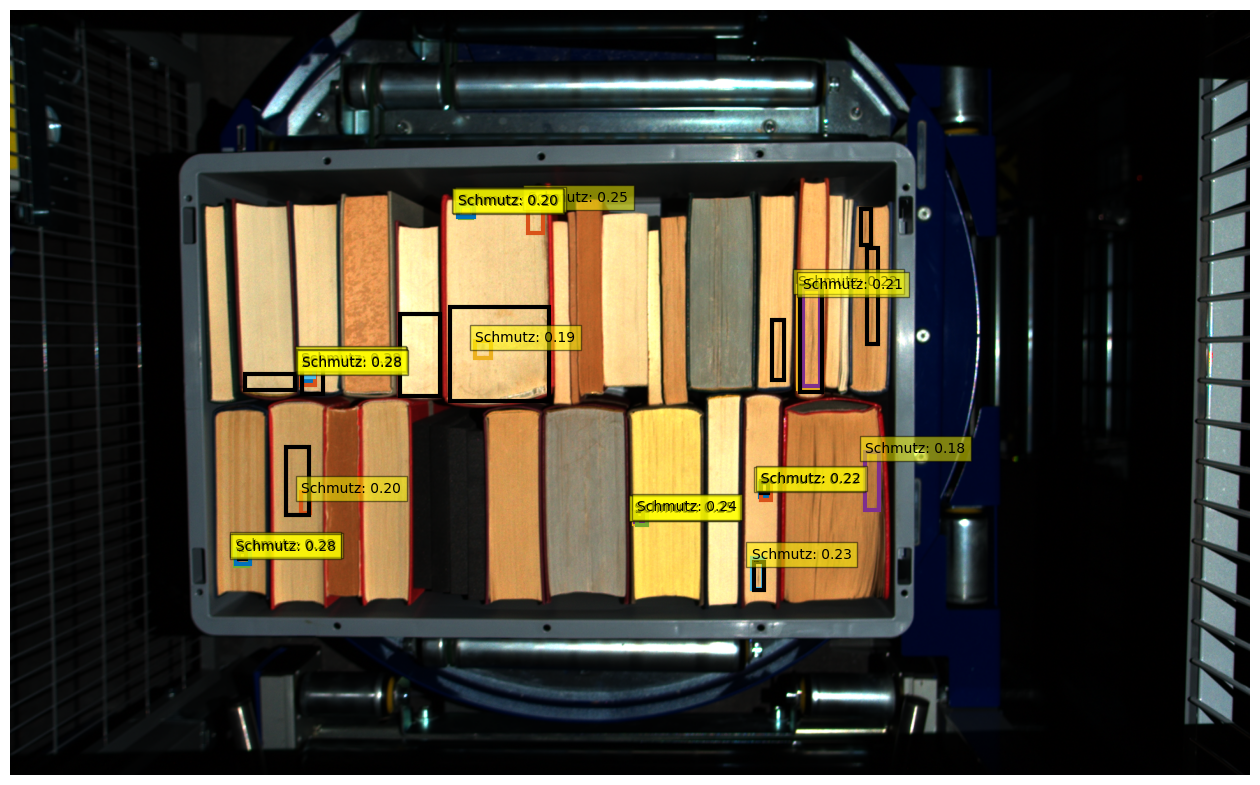

{'scores': tensor([0.3245, 0.3184, 0.3057, 0.3051, 0.3000, 0.2753, 0.2525, 0.2410, 0.2382,
        0.2335, 0.2334, 0.2307, 0.2093, 0.1978, 0.1973, 0.1859, 0.1843, 0.1831],
       device='cuda:0'), 'labels': tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0'), 'boxes': tensor([[1282.1036,  649.6205, 1309.7275,  721.2854],
        [1277.9772,  649.0377, 1312.5922,  706.9285],
        [ 345.0886,  674.7996,  361.7113,  699.6370],
        [ 342.1621,  677.9830,  363.6864,  699.3862],
        [ 346.2351,  677.6572,  364.4825,  695.9726],
        [ 795.5554,  656.9145,  815.1879,  693.6813],
        [1049.6575,  358.9950, 1091.2053,  478.9935],
        [1044.5265,  359.4241, 1090.4380,  518.6617],
        [1154.7156,  672.3775, 1175.9817,  703.5020],
        [1125.3413,  512.7858, 1172.6763,  584.3759],
        [ 633.0382,  709.8462,  649.1871,  731.6382],
        [ 632.6230,  708.1297,  651.2775,  736.5099],
        [1046.2178,  325.1489, 1092.2377,  499.6958],
 

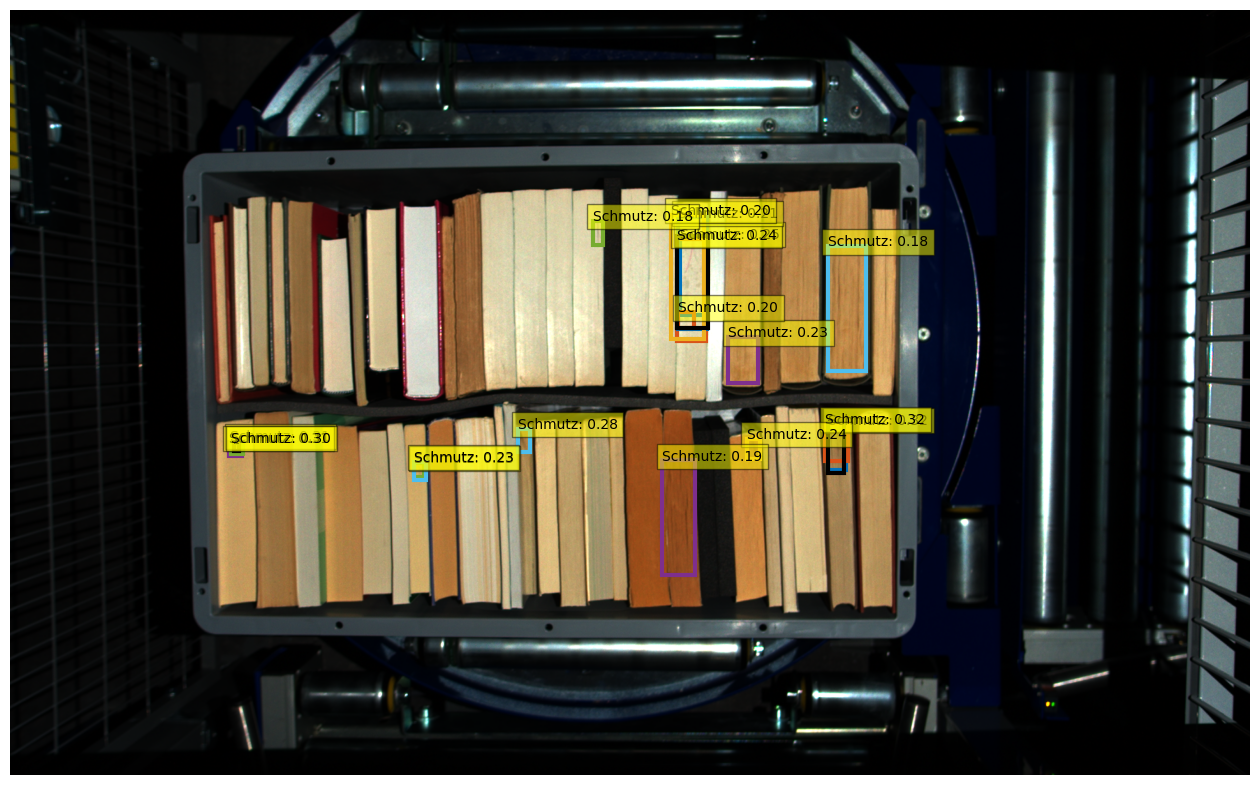

{'scores': tensor([0.3183, 0.3139, 0.2990, 0.2770, 0.2723, 0.2714, 0.2207, 0.2186, 0.2186,
        0.2174, 0.2149, 0.2140, 0.2120, 0.2118, 0.2067, 0.2054, 0.1985, 0.1984,
        0.1974, 0.1951, 0.1928, 0.1818, 0.1808], device='cuda:0'), 'labels': tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0'), 'boxes': tensor([[ 677.5349,  779.9897,  702.4966,  811.5546],
        [ 680.8758,  781.6071,  701.6501,  803.8219],
        [1091.4319,  547.8445, 1123.8469,  584.6498],
        [1248.0286,  621.8523, 1269.4094,  712.9292],
        [1246.2928,  618.3080, 1272.0626,  687.6464],
        [1252.2850,  623.5533, 1271.8197,  707.4614],
        [ 325.7072,  762.1869,  352.6562,  886.8733],
        [1039.6959,  293.0118, 1055.7743,  322.4333],
        [ 556.3370,  845.1432,  585.0660,  868.4198],
        [ 849.9180,  827.2055,  866.8646,  871.5246],
        [ 318.9424,  759.2268,  357.6161,  895.1959],
        [1040.9111,  290.6627, 1057.5885,  329

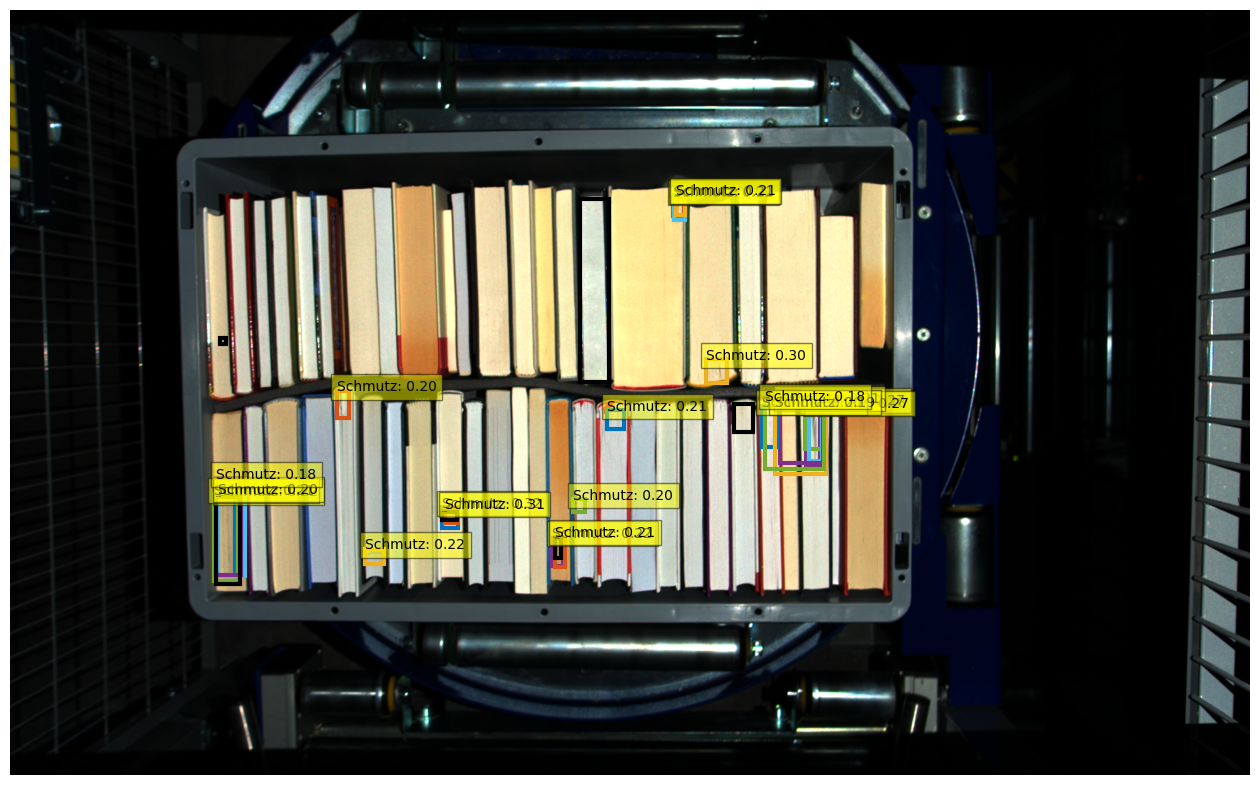

{'scores': tensor([0.3183, 0.3045, 0.2981, 0.2975, 0.2637, 0.2618, 0.2548, 0.2513, 0.2353,
        0.2307, 0.2297, 0.2283, 0.2216, 0.2140, 0.2038, 0.1932, 0.1896, 0.1878,
        0.1866, 0.1837, 0.1837, 0.1837], device='cuda:0'), 'labels': tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0'), 'boxes': tensor([[ 400.2582,  379.2432,  428.6939,  418.9782],
        [ 393.9951,  462.9483,  424.8912,  524.2945],
        [ 396.6561,  465.5377,  421.0869,  498.3142],
        [ 397.7296,  468.4714,  419.1521,  490.1062],
        [ 335.6929,  364.7199,  361.6986,  390.5258],
        [ 458.3381,  503.9647,  503.6181,  532.3730],
        [ 399.0535,  509.3091,  420.6110,  532.0345],
        [ 397.7674,  511.9565,  425.4398,  531.4717],
        [ 459.1328,  389.0731,  497.7466,  446.3046],
        [ 766.8377,  589.4240,  802.2687,  628.5469],
        [ 766.6281,  588.4238,  815.3503,  630.2336],
        [ 766.1861,  588.1069,  831.0637,  633.9881],
   

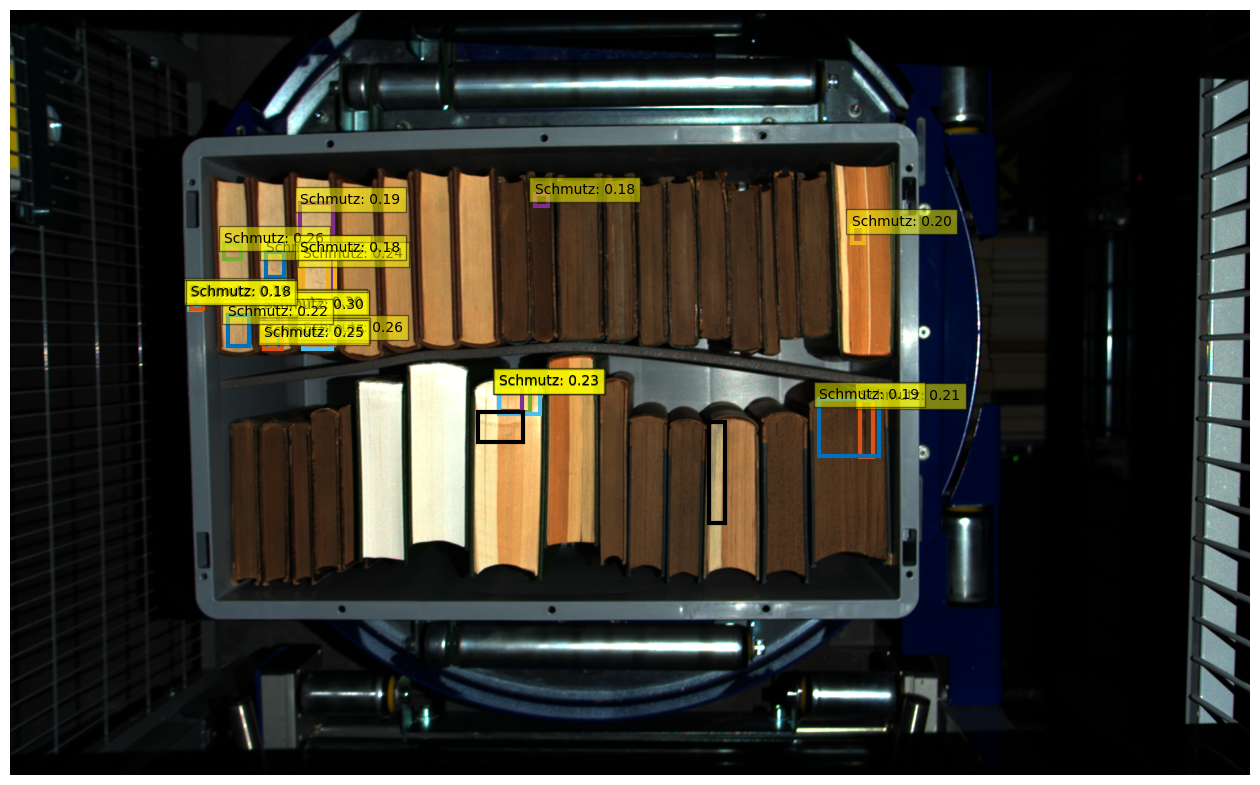

{'scores': tensor([0.2597, 0.2436, 0.2405, 0.2382, 0.2376, 0.2368, 0.2353, 0.2319, 0.2310,
        0.2299, 0.2140, 0.2133, 0.2119, 0.2042, 0.1854], device='cuda:0'), 'labels': tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0'), 'boxes': tensor([[1037.4877,  607.6874, 1059.4160,  648.2407],
        [ 464.9023,  537.0438,  481.5806,  553.3981],
        [ 467.6383,  535.3568,  482.1820,  557.0649],
        [ 464.1284,  532.8882,  482.6818,  558.7328],
        [1285.7422,  613.9507, 1301.6401,  668.4459],
        [1283.5417,  614.2939, 1306.0735,  668.1749],
        [ 468.6795,  536.7093,  483.6376,  553.3947],
        [1283.1122,  601.0441, 1308.3208,  663.5446],
        [1280.9408,  597.2835, 1313.6161,  666.8460],
        [1284.1045,  599.9212, 1301.5565,  664.7237],
        [1040.1262,  864.8300, 1060.5365,  897.3482],
        [1282.2456,  594.4456, 1323.9973,  659.5726],
        [ 988.6659,  826.9111, 1010.2421,  858.5519],
        [ 993.9385,  825.2256, 1011.7106,

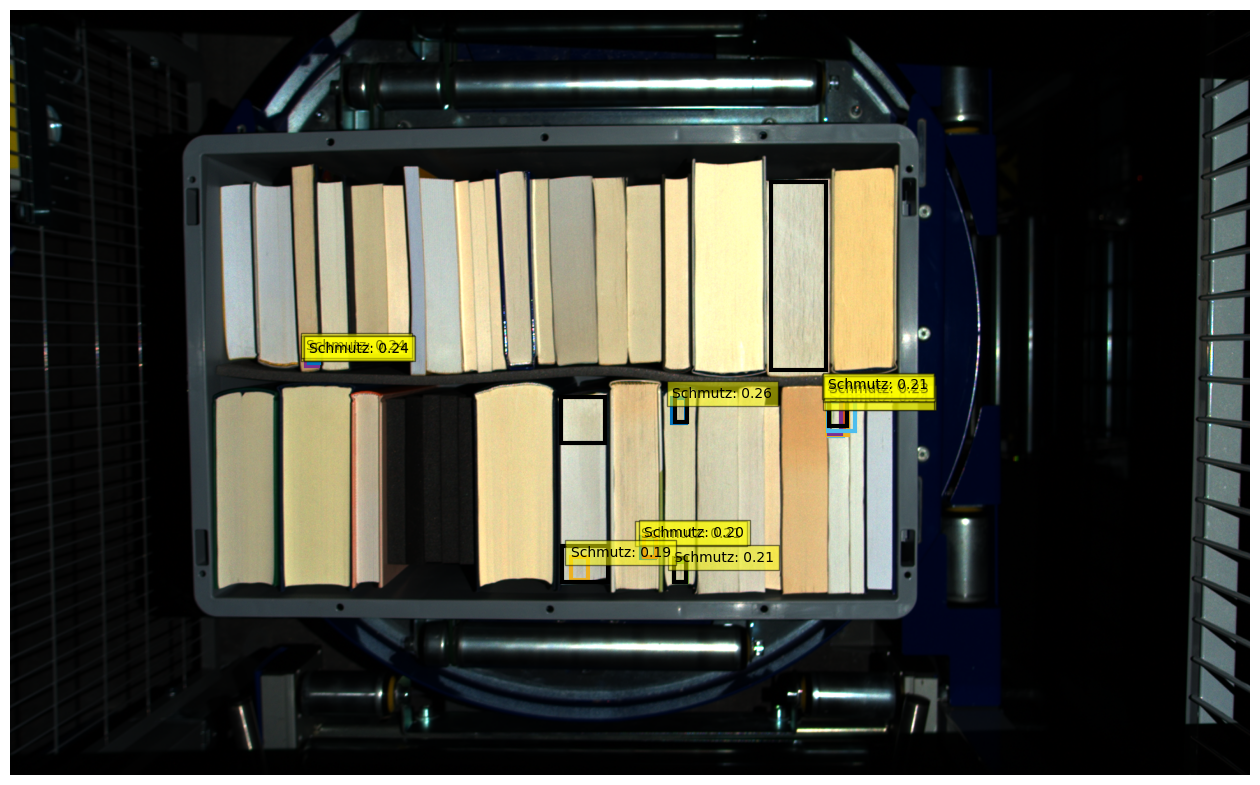

{'scores': tensor([0.2910, 0.2847, 0.2749, 0.2683, 0.2561, 0.2560, 0.2554, 0.2498, 0.2466,
        0.2445, 0.2397, 0.2114, 0.2083, 0.1949, 0.1919, 0.1914, 0.1911, 0.1888,
        0.1873, 0.1859, 0.1842], device='cuda:0'), 'labels': tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0'), 'boxes': tensor([[1058.6447,  334.8242, 1106.6458,  363.3642],
        [ 622.7021,  324.0049,  655.0762,  352.1259],
        [ 401.4921,  791.0468,  418.4872,  808.9421],
        [ 399.9400,  787.1159,  420.0470,  808.9257],
        [ 611.0260,  711.9245,  653.4174,  735.4593],
        [ 611.9590,  707.7810,  662.9702,  734.4801],
        [ 765.8668,  501.2364,  825.3799,  523.5250],
        [ 980.0367,  539.7855,  999.3205,  559.1707],
        [ 976.7572,  539.4218, 1006.2039,  558.4127],
        [ 875.2909,  475.5797,  929.2402,  496.9904],
        [ 974.9744,  537.7305, 1013.2924,  559.2003],
        [ 970.8533,  584.8989, 1031.3528,  602.3339],
        [ 953.

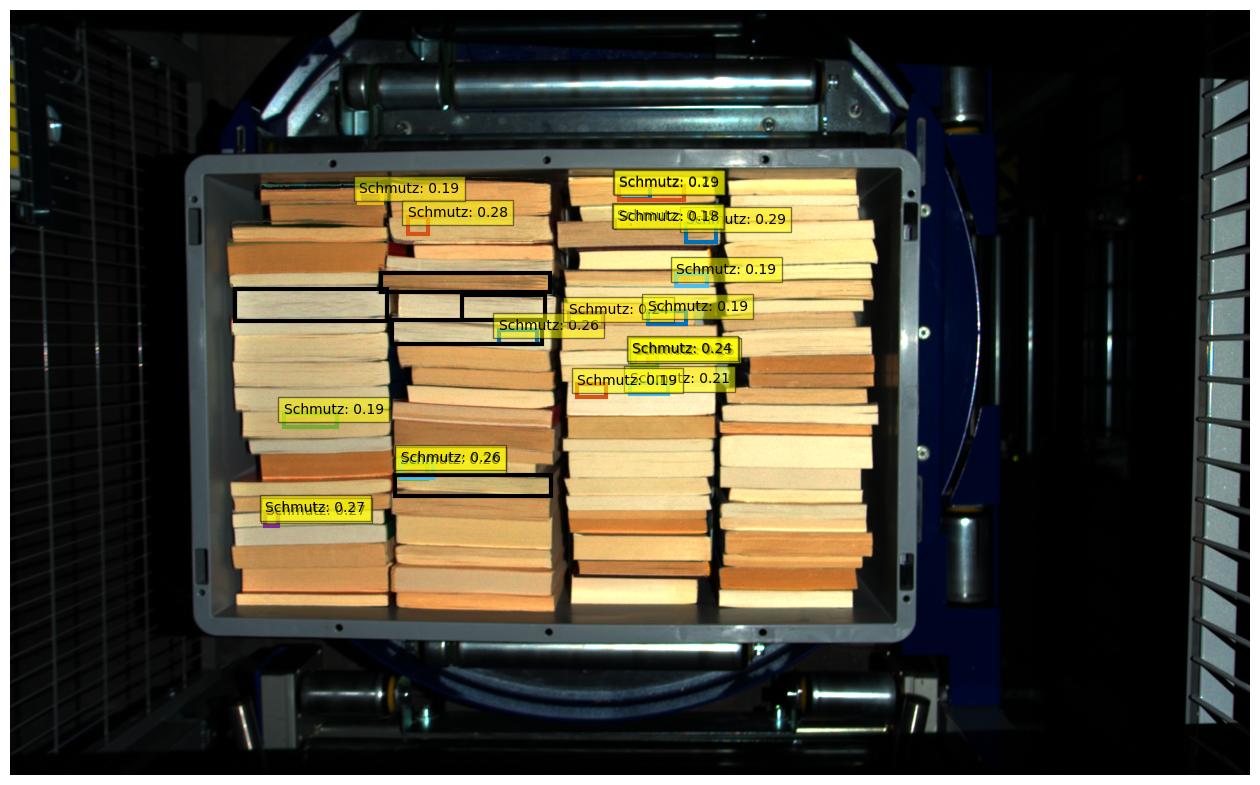

In [10]:
# TODO for a specific label use one specific color
for z in range(6):
    pixel_values, target = val_dataset[z]
    pixel_values = pixel_values.unsqueeze(0).to(device)

    

    annotations = val_dataset.coco.imgToAnns["image_id"]

    with torch.no_grad():
        # forward pass to get class logits and bounding boxes
        outputs = model(pixel_values=pixel_values, pixel_mask=None)

    # colors for visualization
    COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
            [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

    def plot_results(pil_img, scores, labels, boxes, anno):
        plt.figure(figsize=(16,10))
        plt.imshow(pil_img)
        ax = plt.gca()
        colors = COLORS * 100
        types = {}
        for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                fill=False, color=c, linewidth=3))
            text = f'{id2label[label]}: {score:0.2f}'
            textx = text.split(": ")
            if textx[0] in types:
                types.update({textx[0]: types[textx[0]] + 1})
            else: 
                types.update({textx[0]:1})
            ax.text(xmin, ymin, text, fontsize=10,
                    bbox=dict(facecolor='yellow', alpha=0.5))
        print(types)
        
        # draw annotatet boxes
        typesAnno = {}
        color = [0.000, 0.000, 0.000]
        # TODO Resize bbox
        for annot in anno:
            (x, y, w, h) = annot["bbox"]
            (xmin, ymin, xmax, ymax) = (x, y, x + w, y + h)
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                fill=False, color=color, linewidth=3))
            text = f'{id2label[annot["category_id"]]}'
            if text in typesAnno:
                typesAnno.update({text: typesAnno[text] + 1})
            else: 
                typesAnno.update({text:1})
            ax.text(xmin, ymin, text, fontsize=0,
                    bbox=dict(facecolor='black', alpha=0.0))
        print(typesAnno)
        plt.axis('off')
        plt.show()

    # load image based on ID
    image_id = target['image_id'].item()
    image = val_dataset.coco.loadImgs(image_id)[0]
    anno = val_dataset.coco.imgToAnns[image_id]
    image = Image.open(os.path.join('../../../old/BAA/Data/val_Schmutz', image['file_name']))

    # postprocess model outputs
    width, height = image.size
    postprocessed_outputs = processor.post_process_object_detection(outputs,
                                                                    target_sizes=[(height, width)],
                                                                    threshold=0.18)
    results = postprocessed_outputs[0]
    print(results)
    plot_results(image, results['scores'], results['labels'], results['boxes'], anno)